In [1]:
import numpy as np
import cv2
import glob
from functions import *
from matplotlib import pyplot as plt
from itertools import count

In [2]:
CAMERA_ID = 'david'
SESSION_ID = '13-04-2021b'
PROCESSED_OBJECT_IMAGE_NAME = 'result_247_247_4_7.png'
CHESSBOARD_SQUARE_LENGTH_MM = 1
CHESSBOARD_DIMENSIONS = (9,6, CHESSBOARD_SQUARE_LENGTH_MM)
PLANE_CALIBRATION_OBJECT_HEIGHT_MM = 2

## Intrinsic parameter calibration

In [3]:
object_points, image_points, image_dimensions = chessboardPointExtraction(CHESSBOARD_DIMENSIONS,f'data/calibration/{CAMERA_ID}/intrinsic')
ret, intrinsic_matrix, distortion_coefs, rotation_vecs, translation_vecs = cv2.calibrateCamera(object_points, image_points, image_dimensions,None,None)
print('\nImage Dimensions\n', image_dimensions)
print('\nIntrinsic Matrix\n', intrinsic_matrix)
print('\nDistortion Coefficients\n', distortion_coefs)
print(f'\nReprojection error: {calculateReprojectionError(object_points, image_points, rotation_vecs, translation_vecs, intrinsic_matrix, distortion_coefs)}')

100%|██████████| 20/20 [00:14<00:00,  1.35it/s]

Calibration over

Image Dimensions
 (1280, 720)

Intrinsic Matrix
 [[9.95501374e+02 0.00000000e+00 6.59362830e+02]
 [0.00000000e+00 1.00107125e+03 3.60433162e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients
 [[ 0.27103847 -0.58181555 -0.02118469  0.00707566  0.56085949]]

Reprojection error: 0.049253993638239124


## Extrinsic parameter calibration

In [4]:
object_points, image_points, _ = chessboardPointExtraction(CHESSBOARD_DIMENSIONS, f'data/calibration/{CAMERA_ID}/{SESSION_ID}/extrinsic')
object_points_reshaped = np.array(object_points).reshape((-1,3))
image_points_reshaped = np.array(image_points).reshape((-1,2))

# Calculate extrinsic parameter matrices (translation and rotation) using PNP RANSAC
ret, rotation_vecs, translation_vecs, _ = cv2.solvePnPRansac(object_points_reshaped, image_points_reshaped, intrinsic_matrix, distortion_coefs)
print(f'Reprojection error: {calculateReprojectionError(object_points, image_points, rotation_vecs, translation_vecs, intrinsic_matrix, distortion_coefs)}')

100%|██████████| 20/20 [00:00<00:00, 21.48it/s]

Calibration over
Reprojection error: 0.9574133938058408


## Projection Calculation

In [5]:
perspective_projection_matrix = calculatePpmMatrix(intrinsic_matrix, rotation_vecs, translation_vecs)

## Shadow/Light Plane Calibration

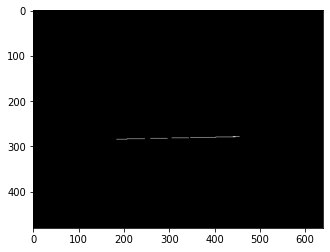

In [6]:
TEMP_SESSION = '13-04-2021b'
flat_image = cv2.imread(f'data/calibration/{CAMERA_ID}/{TEMP_SESSION}/shadow_flat/frame_2021-04-13 21:39:34.254860.png',cv2.IMREAD_GRAYSCALE)
height_image = cv2.imread(f'data/calibration/{CAMERA_ID}/{TEMP_SESSION}/shadow_height/intrujice.png', cv2.IMREAD_GRAYSCALE)
processed_bottom = cv2.imread(f'data/calibration/{CAMERA_ID}/{TEMP_SESSION}/shadow_flat/result_231_233_5_8-clean-clean.png', cv2.IMREAD_GRAYSCALE)
top_lines = cv2.subtract(height_image, processed_bottom)
ret, processed_top = cv2.threshold(top_lines, 240, 255, cv2.THRESH_BINARY)

processed_bottom = processed_bottom
processed_top = height_image
plt.imshow(processed_bottom, cmap='gray')

In [7]:
# Map image 2D coordinates to 3D coordinates

bottom_points = []
top_points = []
shadow_plane_3d_points = []

# 'Floor' points
white_pixel_coords = cv2.findNonZero(processed_bottom)
for pixel in white_pixel_coords:
    point = get_xyz_coords(pixel[0,0],pixel[0,1], perspective_projection_matrix, [[0,0,1,0]]) # z = 0
    bottom_points.append(point)

# Object top points
white_pixel_coords = cv2.findNonZero(processed_top)
for pixel in white_pixel_coords:
    point = get_xyz_coords(pixel[0,0],pixel[0,1], perspective_projection_matrix, [[0,0,1, PLANE_CALIBRATION_OBJECT_HEIGHT_MM]]) # z = PLANE_CALIBRATION_OBJECT_HEIGHT
    top_points.append(point)

# TODO: fix this ad hoc way of assuring the number of top points is the same as the number of bottom points
bottom_points = bottom_points[len(bottom_points)//2 -len(top_points)//2 : len(bottom_points)//2 + len(top_points) // 2]
plane_3d_points = bottom_points
plane_3d_points.extend(top_points)

In [8]:
# Calculate plane coeficients
plane_coefs = calculatePlaneCoefs(np.array(plane_3d_points))
plane_coefs

[-5.594560033215783, 0.34394233333659, -1.0, 2.959242043589649]

## Target object point extraction

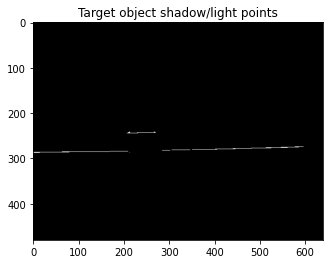

In [9]:
target_object_points = cv2.imread(f'data/calibration/{CAMERA_ID}/{SESSION_ID}/cube_processed/{PROCESSED_OBJECT_IMAGE_NAME}')
target_object_points_gray = cv2.cvtColor(target_object_points, cv2.COLOR_BGR2GRAY)
plt.title('Target object shadow/light points')
plt.imshow(target_object_points, cmap='gray')

In [10]:
# Calculate y and z for points in shadow
points_x = []
points_y = []
points_z = []
white_pixel_coords = cv2.findNonZero(target_object_points_gray)
for pixel in white_pixel_coords:
    x, y, z = get_xyz_coords(pixel[0,0],pixel[0,1], perspective_projection_matrix, [plane_coefs])
    points_y.append(y)
    points_z.append(z)
    points_x.append(x)

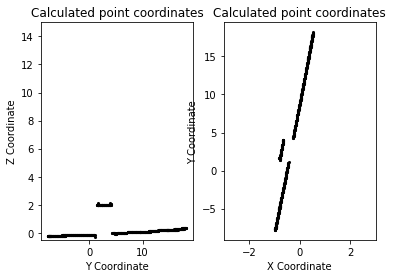

In [11]:
figure, subplots = plt.subplots(1, 2)
subplots[0].set_title('Calculated point coordinates')
subplots[0].set_xlabel('Y Coordinate')
subplots[0].set_ylabel('Z Coordinate')
subplots[0].set_ylim([-0.5,15])
subplots[0].scatter(points_y, points_z, color='black', marker='.', linewidths=0.1)

subplots[1].set_title('Calculated point coordinates')
subplots[1].set_xlabel('X Coordinate')
subplots[1].set_ylabel('Y Coordinate')
subplots[1].set_xlim([-3,3])
subplots[1].scatter(points_x, points_y, color='black', marker='.', linewidths=0.1)